In [220]:
import json
import pprint
import os
import matplotlib.pyplot as plt
import numpy as np
import re
import string
import csv
import itertools
import random
import operator

In [2]:
# Remove all previous results
os.system('rm results/*')

0

In [3]:
all_words = []

def read_file(file_path):
    with open (file_path) as file:
        json_content = json.load(file)
        item_count = 0
        for item in json_content:
            item_count += 1
            text_content = re.sub("<.*?>", "", item["textContent"])
            text_content = text_content.replace('-\n', '')
            word_content = text_content.split()
            topicSpecificPunctuation = '„”–§…«»'
            translator = str.maketrans('', '', string.punctuation+topicSpecificPunctuation)
            
            for word in word_content:
                word = word.translate(translator).lower()
                if len(word)>0:
                    all_words.append(word)
                
        print(item_count)
        
def read_all_judgments_from_2018():
    for filename in os.listdir("data_filtered/"):
        print(filename)
        read_file("data_filtered/" + filename)
        
read_all_judgments_from_2018()
print(len(all_words))

judgments-3163.json
9
judgments-3168.json
100
judgments-3164.json
100
judgments-3171.json
100
judgments-3165.json
100
judgments-3167.json
100
judgments-3169.json
100
judgments-3173.json
81
judgments-3172.json
100
judgments-3166.json
100
judgments-3170.json
100
2530124


In [6]:
flex_to_base_form = {}

def generate_flex_to_base_form_mapping(dictionaryFile):
    with open(dictionaryFile) as f:
        for line in f.readlines():
            base_form, flex_form, meta = line.split(";")
            flex_to_base_form[flex_form.lower()] = base_form.lower()

generate_flex_to_base_form_mapping("polimorfologik-2.1/polimorfologik-2.1.txt")
print(len(flex_to_base_form))

4623718


In [78]:
random.choice(list(flex_to_base_form.keys()))

'zasłynęlibyśmy'

In [23]:
def write_rank_to_file(filename, rank):
    with open(filename, 'a', newline='') as csvfile:
        spamwriter = csv.writer(csvfile, delimiter=',',
            quotechar='|', quoting=csv.QUOTE_MINIMAL)

        rank_possition = 1
        for primary_form, occurrences in rank:
            spamwriter.writerow([rank_possition, primary_form, occurrences])
            rank_possition += 1

In [33]:
CHANGE_TO_BASIC_FORM = False
sorted_rank = []

def generate_rank():        
    words_rank = {}
    for word in all_words:
        if CHANGE_TO_BASIC_FORM:
            if word in flex_to_base_form:
                base_form = flex_to_base_form[word]
            else:
                base_form = word
        else:
            base_form = word
            
        current = words_rank.get(base_form)
        
        if current is None:
            words_rank[base_form] = 1
        else:
            words_rank[base_form] = current + 1
            
    sorted_rank = sorted(words_rank.items(), key = lambda x: x[1], reverse=True)
    return sorted_rank

sorted_rank = generate_rank()
write_rank_to_file('results/fullRank.csv', sorted_rank)
# print(sorted_rank)

In [34]:
filtered_rank = []

def custom_filter(word):
    if re.match("^[a-ząćęłńóśźż]+$", word) and len(word)>1:
        return True
    return False

def filter_rank(rank):
    filtered_rank = filter(lambda x: custom_filter(x[0]), rank)
    return filtered_rank

filtered_rank = filter_rank(sorted_rank)
write_rank_to_file('results/filteredRank.csv', filtered_rank)
# print(filtered_rank)

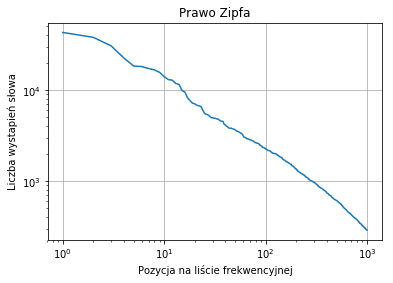

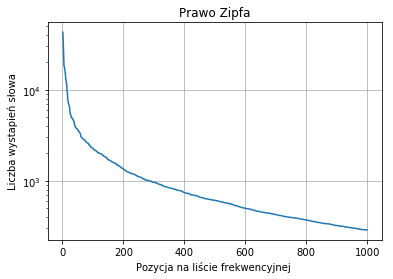

In [35]:
# W skali logarytmicznej przedstaw wykres, 
# w którym na osi X są pozycje na liście frekwencyjnej, 
# a na osi Y liczba wystąpień słowa zajmującego określoną pozycję.

X_values = []
Y_values = []

NUMBER_OF_LINES = 1000

with open('results/filteredRank.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in itertools.islice(reader, 0, NUMBER_OF_LINES):
        X_values.append(row[0])
        Y_values.append(row[2])
        
#plt.semilogy(X_values, Y_values)
plt.loglog(X_values, Y_values)
plt.title('Prawo Zipfa')
plt.xlabel('Pozycja na liście frekwencyjnej')
plt.ylabel('Liczba wystapień słowa')
plt.grid(True)
plt.show()

plt.semilogy(X_values, Y_values)
# plt.loglog(X_values, Y_values)
plt.title('Prawo Zipfa')
plt.xlabel('Pozycja na liście frekwencyjnej ')
plt.ylabel('Liczba wystapień słowa')
plt.grid(True)
plt.show()




In [51]:
# Korzystając z pliku polimorfologik.zip znajdź wszystkie słowa, które nie znajdują się w tym słowniku.
words_not_in_dictionary = []

with open('results/filteredRank.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in reader:
        if row[1] not in flex_to_base_form:
            words_not_in_dictionary.append(row[1])

In [54]:
# Przedstaw 30 przykładowych słów, które nie należą do słownika.
pprint.pprint (words_not_in_dictionary[:30])

['sygn',
 'zw',
 'sa',
 'iv',
 'lex',
 'sso',
 'kpk',
 'viii',
 'dzu',
 'uk',
 'vi',
 'csk',
 'vide',
 'ssr',
 'aua',
 'ssa',
 'kks',
 'osnp',
 'ckn',
 'aca',
 'ix',
 'sekr',
 'legalis',
 'eprotokół',
 'vii',
 'ugh',
 'czp',
 'późn',
 'rc',
 'osnc']


In [190]:
def levensthein_distance(word, distance):
    
    # as in: https://norvig.com/spell-correct.html
    def edits1(word):
        '''
            All edits that are one edit away from `word`."
        '''
        letters    = 'abcdefghijklmnopqrstuvwxyząćęłńóśżź'
        splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
        deletes    = [L + R[1:]               for L, R in splits if R]
        transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
        replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
        inserts    = [L + c + R               for L, R in splits for c in letters]
        return set(deletes + transposes + replaces + inserts)
    
    if distance == 1:
        return edits1(word)
    else:
        partial_results = edits1(word)
        for dist in range(1, distance):
            new_partial_results = [edits1(x) for x in partial_results]
            partial_results = new_partial_results
        return set(itertools.chain(*partial_results))


In [191]:
def valid_words_in_dictionary(words):
    return {word for word in words if word in flex_to_base_form.keys()}

In [216]:
def frequence_list_for_words(words, filtered_rank):
    new_dict = {}
    for word in words:
        if word in filtered_rank:
            new_dict[word] = filtered_rank[word]
    return new_dict
        

In [244]:
def correct_word(word):
    words = (valid_words_in_dictionary(levensthein_distance(word, 2)))
    freq_subst = frequence_list_for_words(words, filtered_rank)
    sorted_freq_subst = sorted(freq_subst.items(), key=operator.itemgetter(1), reverse=True)
    return sorted_freq_subst[:1][0][0]

In [245]:
filtered_rank = dict(filter_rank(sorted_rank))

In [248]:
# pprint.pprint(correct_word("abc"))
for word in words_not_in_dictionary[:30]:
    pprint.pprint(word + " " + correct_word(word))


'sygn stan'
'zw na'
'sa na'
'iv na'
'lex że'
'sso do'
'kpk po'
'viii ii'
'dzu do'
'uk na'
'vi na'
'csk co'
'vide nie'
'ssr się'
'aua na'
'ssa na'
'kks akt'
'osnp sp'
'ckn co'
'aca na'
'ix na'
'sekr spr'
'legalis legalne'
'eprotokół protokół'
'vii nie'
'ugh ust'
'czp za'
'późn pkn'
'rc na'
'osnc on'
